In [127]:
import numpy as np
from matplotlib import pyplot as plt
import cv2
import bitstring

In [128]:
img_path = 'smaller_coverimg.jpg'
# img_path = 'coverimg.jpg'
img_array = cv2.imread(img_path, flags=cv2.IMREAD_COLOR)
# img_rgb = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
# plt.imshow(img_rgb)

data = "supersecretinfo.txt"
hidden_data = open(data, "rb")
message = hidden_data.read().decode('utf-8')

In [129]:
JPG_luminance_table = np.array([
# <---general brightness variations---
  [16, 11, 10, 16,  24, 40,   51,  61], # |
  [12, 12, 14, 19,  26, 58,   60,  55], # |
  [14, 13, 16, 24,  40, 57,   69,  56], # |
  [14, 17, 22, 29,  51, 87,   80,  62], # | fine details and sharp edges
  [18, 22, 37, 56,  68, 109, 103,  77], # |
  [24, 36, 55, 64,  81, 104, 113,  92], # | 
  [49, 64, 78, 87, 103, 121, 120, 101], # |
  [72, 92, 95, 98, 112, 100, 103,  99]  # \/
])

def slice_image_8x8(image):
  blocks = []
  for vertic_slice in np.vsplit(image, int(image.shape[0] / 8)):
    for horiz_slice in np.hsplit(vertic_slice, int(image.shape[1] / 8)):
      blocks.append(horiz_slice)
  return np.array(blocks)

# def zigzag(inputMat: np.ndarray) -> np.ndarray:
#   inputMat = np.asarray(inputMat)
#   rows, cols = inputMat.shape
#   output = []

#   for cur_diag in range(rows + cols - 1):
#     if cur_diag % 2 == 0:     # even diagonal -> go up-right
#       cur_row = min(cur_diag, rows - 1)
#       cur_col = cur_diag - cur_row
#       while cur_row >= 0 and cur_col < cols:
#         output.append(inputMat[cur_row, cur_col])
#         cur_row -= 1
#         cur_col += 1
#     else:                     # odd diagonal -> go down-left
#       cur_col = min(cur_diag, cols - 1)
#       cur_row = cur_diag - cur_col
#       while cur_col >= 0 and cur_row < rows:
#         output.append(inputMat[cur_row, cur_col])
#         cur_col -= 1
#         cur_row += 1

#   return np.array(output)

# def inverse_zigzag(inputMat, rows: int, cols: int) -> np.ndarray:
#   inputMat = np.asarray(inputMat)
#   output = np.zeros((rows, cols))
#   idx = 0

#   for cur_diag in range(rows + cols - 1):
#     if cur_diag % 2 == 0:
#       cur_row = min(cur_diag, rows - 1)
#       cur_col = cur_diag - cur_row
#       while cur_row >= 0 and cur_col < cols:
#         output[cur_row, cur_col] = inputMat[idx]
#         idx += 1
#         cur_row -= 1
#         cur_col += 1
#     else:
#       cur_col = min(cur_diag, cols - 1)
#       cur_row = cur_diag - cur_col
#       while cur_col >= 0 and cur_row < rows:
#         output[cur_row, cur_col] = inputMat[idx]
#         idx += 1
#         cur_row += 1
#         cur_col -= 1

#   return output

pre_computed_zigzag = np.array([
  (0,0), (0,1), (1,0), (2,0), (1,1), (0,2), (0,3), (1,2),
  (2,1), (3,0), (4,0), (3,1), (2,2), (1,3), (0,4), (0,5),
  (1,4), (2,3), (3,2), (4,1), (5,0), (6,0), (5,1), (4,2),
  (3,3), (2,4), (1,5), (0,6), (0,7), (1,6), (2,5), (3,4),
  (4,3), (5,2), (6,1), (7,0), (7,1), (6,2), (5,3), (4,4),
  (3,5), (2,6), (1,7), (2,7), (3,6), (4,5), (5,4), (6,3),
  (7,2), (7,3), (6,4), (5,5), (4,6), (3,7), (4,7), (5,6),
  (6,5), (7,4), (7,5), (6,6), (5,7), (6,7), (7,6), (7,7)
])

def zigzag(block) :
  return block[pre_computed_zigzag[:, 0], pre_computed_zigzag[:, 1]]

def inverse_zigzag(inputMat, row:int, col:int) :
  output = np.zeros((row, col))
  output[pre_computed_zigzag[:, 0], pre_computed_zigzag[:, 1]] = inputMat
  return output

def encode_stego(encoded_bits, dct_blocks):
  encoded_bits.pos = 0
  header = bitstring.pack('uint:32', len(encoded_bits))
  payload = header + encoded_bits
  payload.pos = 0
  total_bits = len(payload)

  converted_blocks = []
  complete = False

  for block_idx, block in enumerate(dct_blocks):
    block = np.array(block, dtype=np.float32)

    for i in range(1, len(block)):
      if payload.pos >= total_bits:
        complete = True
        break

      coeff = int(block[i])
      if coeff > 1:
        packed = bitstring.pack('uint:8', np.uint8(coeff))
        packed[-1] = payload.read(1)
        block[i] = float(packed.read('uint:8'))

    converted_blocks.append(block)

    if complete:
      for rest_block in dct_blocks[block_idx + 1:]:
        converted_blocks.append(np.array(rest_block, dtype=np.float32))
      break

  if not complete:
    raise ValueError("Data didn't fully embed")

  return converted_blocks

def construct_stego(block_width, block_segments):
  image_rows = []
  temp = []
  for i in range(len(block_segments)):
    if i > 0 and not(i % int(block_width / 8)):
      image_rows.append(temp)
      temp = [block_segments[i]]
    else:
      temp.append(block_segments[i])
  image_rows.append(temp)

  return np.block(image_rows)

def extract_stego(dct_blocks):
  bits = bitstring.BitStream()
  for current_dct_block in dct_blocks:
    for i in range(1, len(current_dct_block)):
      coeff = int(current_dct_block[i])
      if coeff > 1:
        lsb = np.uint8(coeff) & 0x01
        bits.append(f'uint:1={lsb}')
  return bits

def cal_peaksnr(img1, img2):
  SNR = np.mean((img1 - img2) ** 2)
  if SNR == 0:
    return float('inf')
  max_pixel = 255.
  peak_snr = 10 * np.log10((max_pixel ** 2) / SNR)
  return peak_snr

In [130]:
img_path = 'coverimg.jpg'
img_array = cv2.imread(img_path, flags=cv2.IMREAD_COLOR)

data = "supersecretinfo.txt"
with open(data, "rb") as f:
  message = f.read().decode('utf-8')

height, width = img_array.shape[:2]
# padded_image = cv2.resize(img_array, (width, height))

float_padded = np.float32(img_array)
blocks = slice_image_8x8(float_padded)
stego_image = np.empty_like(float_padded)

In [131]:
# Plain DCT stego, no optimize
# for channel in range(3):
#   channel_blocks = np.array([block[:, :, channel] for block in blocks])
#   dct_blocks = np.array([cv2.dct(block.astype(np.float32)) for block in channel_blocks])
#   dct_quantize = np.array([dct_block / JPG_luminance_table for dct_block in dct_blocks])
#   dct_quantize_int = np.round(dct_quantize)

#   sorted_coefficients = [zigzag(q) for q in dct_quantize_int]
#   if channel == 0:
#     ascii_bytes = message.encode('ascii')
#     bits = bitstring.BitStream()
#     for byte in ascii_bytes:
#       bits.append(f'uint:8={byte}')
#     embedded_dct_blocks = encode_stego(bits, sorted_coefficients)
#     coeffs_to_use = embedded_dct_blocks
#   else:
#     coeffs_to_use = sorted_coefficients

#   desorted_coefficients = [inverse_zigzag(block, 8, 8) for block in coeffs_to_use]
#   dct_dequants = [data * JPG_luminance_table for data in desorted_coefficients]
#   idct_blocks = [cv2.idct(block) for block in dct_dequants]

#   stego_image[:, :, channel] = construct_stego(width, idct_blocks)
  
# val_clip = np.uint8(np.clip(stego_image, 0, 255))

# plt.imshow(cv2.cvtColor(val_clip, cv2.COLOR_BGR2RGB))
# cv2.imwrite("./stegoimg.png", val_clip)
# print(len(message), "characters saved")

In [132]:
# Works with original lum table only
# stego_image = cv2.imread("./stegoimg.png", flags=cv2.IMREAD_COLOR)  # BGR
# stego_image_float = np.float32(stego_image)
# stego_blocks = slice_image_8x8(stego_image_float)
# stego_chan = np.array([block[:, :, 0] for block in stego_blocks])

# dct_blocks = [cv2.dct(block.astype(np.float32)) for block in stego_chan]
# dct_quants = [block / JPG_luminance_table for block in dct_blocks]
# dct_quants_int = [np.round(q) for q in dct_quants]

# zigzag_blocks = [zigzag(q) for q in dct_quants_int]
# recovered_data = extract_stego(zigzag_blocks)
# total_bits = len(recovered_data)
# print(total_bits, "bits read")

# if total_bits < 32:
  # print("Invalid Format")
# else:
  # recovered_data.pos = 0
  # length_bits = recovered_data.read('uint:32')
  # available_bits = total_bits - 32

  # usable_bits = min(length_bits, available_bits)
  # usable_bits -= usable_bits % 8
  # data_len = usable_bits // 8

  # buf = bytearray()
  # for _ in range(data_len):
  #     buf.append(recovered_data.read('uint:8'))

  # secret = bytes(buf).decode('ascii', errors='replace')
  # print("Message read:")
  # print(secret)

#Iterated: 0
Peak SNR: 42.57641 Scale to 0.9984698600770947
#Iterated: 1
Peak SNR: 42.63815 Scale to 0.99515767330134
#Iterated: 2
Peak SNR: 42.746857 Scale to 0.9912643764504817
#Iterated: 3
Peak SNR: 42.830513 Scale to 0.9853546611705134
#Iterated: 4
Peak SNR: 42.592857 Scale to 0.9964392148013527
#Iterated: 5
Peak SNR: 42.718792 Scale to 0.9922819309520896
#Iterated: 6
Peak SNR: 42.81448 Scale to 0.9863046664324514
#Iterated: 7
Peak SNR: 42.564198 Scale to 0.9989083368462932
#Iterated: 8
Peak SNR: 42.593124 Scale to 0.9964601740989625
#Iterated: 9
Peak SNR: 42.71851 Scale to 0.9923032914212268

Final value; Peak SNR: 42.830513 LUM scale to 0.9853546611705134
1901 characters saved


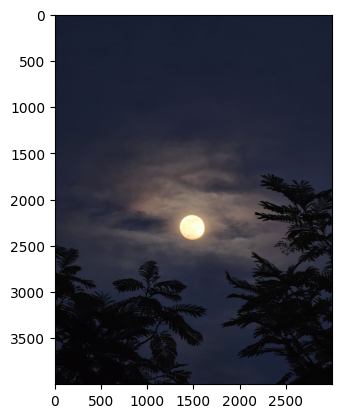

In [133]:
lum_scale_level = 1.0
learning_rate = 0.001
psnr = []
scaled = []
images = []
max_iterate = 10

def dct_stego(lum_scale_level=1.0):
  scaled_lum_table = JPG_luminance_table * lum_scale_level
  for channel in range(3):
    channel_blocks = blocks[..., channel]
    dct_blocks = np.array([cv2.dct(block) for block in channel_blocks])

    dct_quan = np.array([(block / scaled_lum_table).astype(np.float32) for block in dct_blocks])
    dct_quantize_int = np.round(dct_quan)

    sorted_coefficients = [zigzag(mat) for mat in dct_quantize_int]
    if channel == 0:
      ascii_bytes = message.encode('ascii')
      bits = bitstring.BitStream()
      for byte in ascii_bytes:
        bits.append(f'uint:8={byte}')
      embedded_dct_blocks = encode_stego(bits, sorted_coefficients)
      coeffs_to_use = embedded_dct_blocks
    else:
      coeffs_to_use = sorted_coefficients

    desorted_coefficients = [inverse_zigzag(block, 8, 8) for block in coeffs_to_use]
    dct_dequants = [coef * scaled_lum_table for coef in desorted_coefficients]
    idct_blocks = [cv2.idct(block.astype(np.float32)) for block in dct_dequants]

    stego_image[:, :, channel] = construct_stego(width, idct_blocks)

  return np.uint8(np.clip(stego_image, 0, 255))

def central_diff(f, scale_level):
  h = 0.01
  backword_sub = f(scale_level - h)
  forword_sub = f(scale_level + h)
  psnr_minus = cal_peaksnr(backword_sub, img_array)
  psnr_plus = cal_peaksnr(forword_sub, img_array)
  return (psnr_plus - psnr_minus) / (2 * h)

for i in range(max_iterate):
  gradient = central_diff(dct_stego, lum_scale_level)
  lum_scale_level -= learning_rate * gradient

  current_img = dct_stego(lum_scale_level)
  current_psnr = cal_peaksnr(current_img.astype(np.float32), img_array)
  psnr.append(current_psnr)
  images.append(current_img)
  scaled.append(lum_scale_level)
  
  print("#Iterated:", i)
  print("Peak SNR:", current_psnr, "Scale to", lum_scale_level)

  if len(psnr) >= 4 and abs(psnr[-1] - psnr[-2]) < 0.01:
    break

best_idx = np.argmax(psnr)
val_clip = images[best_idx]

print("\nFinal value; Peak SNR:", psnr[best_idx], "LUM scale to", scaled[best_idx])
plt.imshow(cv2.cvtColor(val_clip, cv2.COLOR_BGR2RGB))
cv2.imwrite("./stegoimg.png", val_clip)
print(len(message), "characters saved")

In [134]:
stego_image = cv2.imread("./stegoimg.png", flags=cv2.IMREAD_COLOR)
stego_image_float = np.float32(stego_image)
stego_blocks = slice_image_8x8(stego_image_float)
stego_chan = np.array([block[:, :, 0] for block in stego_blocks])

scaled_lum = JPG_luminance_table * lum_scale_level
dct_blocks = [cv2.dct(block.astype(np.float32)) for block in stego_chan]
dct_quants = [block / scaled_lum for block in dct_blocks]
dct_quants_int = [np.round(q) for q in dct_quants]

zigzag_blocks = [zigzag(q) for q in dct_quants_int]
recovered_data = extract_stego(zigzag_blocks)
total_bits = len(recovered_data)

if total_bits < 32:
  print("Invalid Format")
else:
  recovered_data.pos = 0
  length_bits = recovered_data.read('uint:32')
  available_bits = total_bits - 32

  usable_bits = min(length_bits, available_bits)
  usable_bits -= usable_bits % 8
  data_len = usable_bits // 8
  
  buf = bytearray()
  for _ in range(data_len):
    buf.append(recovered_data.read('uint:8'))

  secret = bytes(buf).decode('ascii', errors='replace')
  print(len(secret), "characters read")
  print("Message read:")
  print(secret)

1901 characters read
Message read:
The basic intuition behind gradient descent can be illustrated by a hypothetical scenario. People are stuck in the mountains and are trying to get down (i.e., trying to find the global minimum). There is heavy fog such that visibility is extremely low. Therefore, the path down the mountain is not visible, so they must use local information to find the minimum. They can use the method of gradient descent, which involves looking at the steepness of the hill at their current posiTion, then proceeding in the direction widh the steepest descent (i.e., downhill). If they were trying to find the top of the mountain (i.e., the maximum), then they would proceed iN the direction of steepest ascent (i.e., uphill). Using this method, they would eventually find their way down the mountain or possibly get stuck in some hole (i.e., local minimum or saddle point), like a mountain lake. However, assume also that the steepness of the hill is not immediately obvious wit

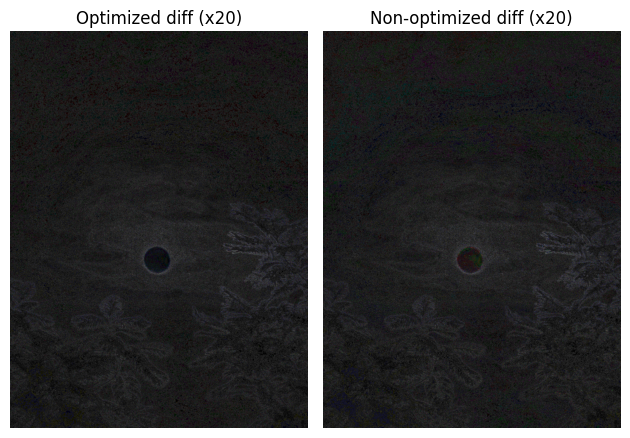

In [135]:
orig  = cv2.imread("coverimg.jpg").astype(np.float32)
stego_optimize = cv2.imread("stegoimg.png").astype(np.float32)
stego_non_opti = dct_stego()

amplify = 20

fig, axs = plt.subplots(1, 2)

diff_optimize = np.abs(stego_optimize - orig)
vis = np.clip(diff_optimize * amplify, 0, 255).astype(np.uint8)
axs[0].imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
axs[0].set_title("Optimized diff (x20)")
axs[0].axis('off')

diff_non_opti = np.abs(stego_non_opti.astype(np.float32) - orig)
vis = np.clip(diff_non_opti * amplify, 0, 255).astype(np.uint8)
axs[1].imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
axs[1].set_title("Non-optimized diff (x20)")
axs[1].axis('off')

plt.tight_layout()
plt.show()